<a href="https://colab.research.google.com/github/tsaland/COS-473-Final-Project/blob/main/WhaleWatch_LSTM_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 0: Signal Detection

Current market signals include:
- Whales net exchange flow
- Whales eth balance
- Whales eth-to-stablecoin ratio
- Eth volume on DEXs
- Aave's WETH stable interest rates.

Next signals to collect include:
- Prices of ETH call/put options and futures
- %age of ETH supply that is staked (only valid for post-merge data so might not be much)
- Twitter
  - Specific hashtags or accounts
  - Sentiment
- 



# Part I: Data Pre-processing



Upload and normalize collected data from local files, including whales' net exchange flows, account balance, and eth-to-stablecoin ratio

In [4]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1kx9Kjn8yU69WOJT7BjsVWu-5uk9bHtNq' -O 'MWUA_eth2stable.csv'
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1grm281lRVoFSp9NSzn-hmKJSpd15WAoD' -O 'x_ethdexvolume.csv'
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=147qKOTk2GMuD1ciOzKgwt3-AOe9zC4zE' -O 'MWUA_cexflow.csv'
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=12aZyfJarYdiOC5UTZrErgbLQvJgCpSFU' -O 'x_aavestableir.csv'
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1wqueZvPectpL7WcO-NJix9FndW7dRqKB' -O 'MWUA_balance.csv'
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1EzUrOFbPjPeI2K_aNyez1_CyG9vRmLxg' -O 'y_ethprice.csv'

--2023-05-14 17:54:37--  https://docs.google.com/uc?export=download&id=1kx9Kjn8yU69WOJT7BjsVWu-5uk9bHtNq
Resolving docs.google.com (docs.google.com)... 142.251.2.100, 142.251.2.102, 142.251.2.101, ...
Connecting to docs.google.com (docs.google.com)|142.251.2.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0o-78-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/4ub8v9ogghtrcl1nmvjv1ldb4hc6fdp7/1684086825000/07247836654369937745/*/1kx9Kjn8yU69WOJT7BjsVWu-5uk9bHtNq?e=download&uuid=6b88369e-d50d-477e-9936-746f90b6c780 [following]
--2023-05-14 17:54:37--  https://doc-0o-78-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/4ub8v9ogghtrcl1nmvjv1ldb4hc6fdp7/1684086825000/07247836654369937745/*/1kx9Kjn8yU69WOJT7BjsVWu-5uk9bHtNq?e=download&uuid=6b88369e-d50d-477e-9936-746f90b6c780
Resolving doc-0o-78-docs.googleusercontent.com (doc-0o-78-docs.googleusercontent.com)... 142.250.141.132, 2607:f8b0:402

In [29]:
# Process Data
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import torch
scaler = MinMaxScaler()

# read eth price
inFile = '/content/y_ethprice.csv'
y_price_change = []
eth_price = []
with open(inFile) as f:
  for row in f:
    if row.split(',')[2]: 
      prev_price = np.float32(row.split(',')[2])
      today_price = np.float32(row.split(',')[1])
      percent_change = (today_price - prev_price) / prev_price
      y_price_change.append(percent_change)
      eth_price.append(today_price)

print("first eth price % change is", y_price_change[0])
y_price_change = np.array(y_price_change).reshape(365, 1)

# read cex flow
# inFile = '/content/x_cexflow csv.csv'
inFile = '/content/MWUA_cexflow.csv'
x_cexflow = []
with open(inFile) as f:
  for row in f:
    if row.split(',')[1]:
      net_cexflow = row.split(',')[1]
      x_cexflow.append(np.float32(net_cexflow))

print("first cex flow is", x_cexflow[0])
x_cexflow = scaler.fit_transform(np.array(x_cexflow).reshape(365, 1))

# read eth balance
# inFile = '/content/x_ethbalance csv.csv'
inFile = '/content/MWUA_balance.csv'
x_balance = []
with open(inFile) as f:
  for row in f:
   if row.split(',')[0]:
      prev_balance = np.float32(row.split(',')[2])
      today_balance = np.float32(row.split(',')[1])
      percent_change = (today_balance - prev_balance) / prev_balance
      x_balance.append(np.float32(percent_change))

print("first balance % change is", x_balance[0])
x_balance = np.array(x_balance).reshape(365, 1)

# read eth to stables ratio
# inFile = '/content/x_eth2stables csv.csv'
inFile = '/content/MWUA_eth2stable.csv'
x_eth2stables = []
with open(inFile) as f:
  for row in f:
    if row.split(',')[0]:
      eth_to_stables = row.split(',')[1]
      x_eth2stables.append(np.float32(eth_to_stables))

print("first eth2stable is", x_eth2stables[0])
x_eth2stables = scaler.fit_transform(np.array(x_eth2stables).reshape(365, 1))

# read dex eth trading volume
inFile = '/content/x_ethdexvolume.csv'
x_dexvolume = []
with open(inFile) as f:
  for row in f:
    if row.split(',')[2]:
      prev_volume = np.float32(row.split(',')[2])
      today_volume = np.float32(row.split(',')[1])
      percent_change = (today_volume - prev_volume) / prev_volume
      x_dexvolume.append(np.float32(percent_change))

print("first dex volume % change is", x_dexvolume[0])
x_dexvolume = np.array(x_dexvolume).reshape(365, 1)

# read aave V2 weth stable interest rate 
inFile = '/content/x_aavestableir.csv'
x_interest_rate = []
with open(inFile) as f:
  for row in f:
    ir = row.split(',')[1]
    if ir:
      x_interest_rate.append(np.float32(ir))

print("first interest rate is", x_interest_rate[0])
x_interest_rate = scaler.fit_transform(np.array(x_interest_rate).reshape(365, 1))

# aggregate all inputs into a single numpy array
x_input = []
for row in range(len(x_cexflow)):
  input_row = []
  input_row.append(x_cexflow[row][0])
  input_row.append(x_balance[row][0])  
  input_row.append(x_eth2stables[row][0])
  input_row.append(x_dexvolume[row][0])
  input_row.append(x_interest_rate[row][0])
  x_input.append(input_row)

x_input = np.array(x_input)
print("training input has shape", x_input.shape)
print(x_input[0])


first eth price % change is 0.018226137
first cex flow is -0.705
first balance % change is 0.36982656
first eth2stable is 0.004888081
first dex volume % change is -0.18120134
first interest rate is 0.033411827
training input has shape (365, 5)
[ 9.4405580e-01  3.6982656e-01  4.6354461e-02 -1.8120134e-01
  1.4926866e-04]


# Part II: Training

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import matplotlib.ticker as mtick

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out)
        return out


def LSTM_model():
    # load data and make training set
    train_split = 219
    train_input = torch.from_numpy(x_input[:train_split, :])  # train_split, 3
    # train_split, 1 -- eth price returns = (p_{t+1}-p_{t})/p_{t}
    train_target = torch.from_numpy(y_price_change[:train_split, :])

    train_target_shifted_right = torch.from_numpy(
        y_price_change[1:train_split-1, :])  # 324, 1 -- shifted eth price returns
    # train_split, 1 -- shifted eth price returns

    # 325, 4 -- added shifted eth price to the input
    train_input = torch.cat((train_input, train_target_shifted_right), 1)
    print(train_input.shape)

    val_batch = 73
    test_input = torch.from_numpy(
        x_input[train_split:train_split + val_batch, :])  # 20, 4
    test_target = torch.from_numpy(
        y_price_change[train_split:train_split + val_batch, :])  # 20, 1

    test_target_shifted_right = torch.from_numpy(
        y_price_change[train_split-1:train_split-1 + val_batch, :])  # 20, 1 -- shifted eth price returns
    print(test_target_shifted_right.shape)
    # 20, 4 -- added shifted eth price to the input
    test_input = torch.cat((test_input, test_target_shifted_right), 1)
    print(test_input.shape)

    # build the model
    input_signals = len(x_input[0])
    model = LSTM(input_signals+1, 64, 2, 1, dropout=0.2)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=5e-3)
    n_steps = 100
    validate_every = 10
    validation_loss_threshold = 0.0000001

    #begin to train
    model.train()
    for i in range(n_steps):
        out = model(train_input)

        optimizer.zero_grad()
        loss = criterion(out, train_target)
        loss.backward()
        optimizer.step()  # causes the optimizer to take a step based on the gradients
        # begin to predict, no need to track gradient here
        if i % validate_every == 0:
            print('STEP: ', i)
        with torch.no_grad():  # temporarily sets all of the requires_grad flags to false, deactives autograd function, for model validation
            pred = model(test_input)
            val_loss = criterion(pred, test_target)
            print('val loss:', loss.item())
            y = pred.detach().numpy()
            if val_loss < validation_loss_threshold:
                break

    return model

# Part III: Evaluation

torch.Size([219, 6])
torch.Size([73, 1])
torch.Size([73, 6])
STEP:  0
val loss: 0.004021432716399431
val loss: 0.011499223299324512
val loss: 0.00321992882527411
val loss: 0.0030214935541152954
val loss: 0.0044691613875329494
val loss: 0.0043711112812161446
val loss: 0.0034713742788881063
val loss: 0.002730870619416237
val loss: 0.002498773392289877
val loss: 0.002647264627739787
STEP:  10
val loss: 0.0029199777636677027
val loss: 0.0030920119024813175
val loss: 0.002998183947056532
val loss: 0.0027991014067083597
val loss: 0.002621764549985528
val loss: 0.0024819509126245975
val loss: 0.002492791973054409
val loss: 0.0025259358808398247
val loss: 0.0026157076936215162
val loss: 0.002648127730935812
STEP:  20
val loss: 0.002635388169437647
val loss: 0.0025893915444612503
val loss: 0.0025506627280265093
val loss: 0.0024848254397511482
val loss: 0.0024453182704746723
val loss: 0.002416800707578659
val loss: 0.0024632010608911514
val loss: 0.002460543531924486
val loss: 0.0024793646298348

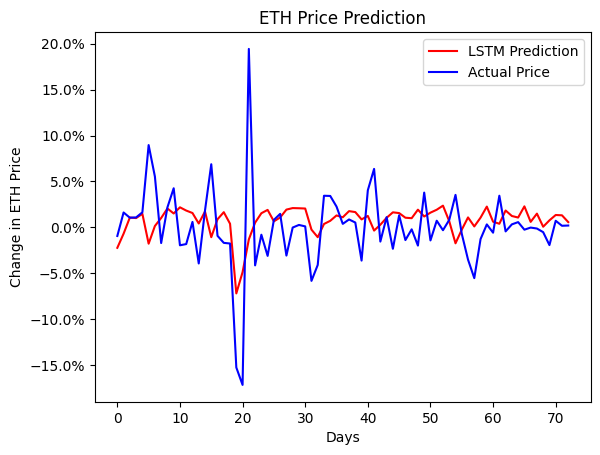

/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


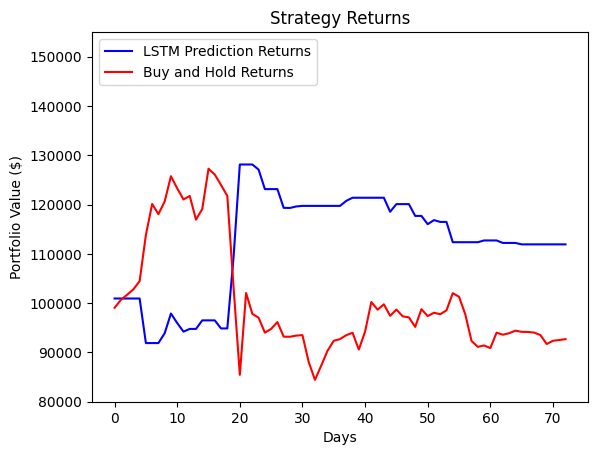

In [30]:
# Test model using last 73 days of data
model = LSTM_model()
model.eval()

torch.manual_seed(42)
test_split = 73
test_input = torch.from_numpy(x_input[-test_split:, :])  # train_split, 3
test_target = torch.from_numpy(y_price_change[-test_split:, :])
print(test_target.shape)

test_target_shifted_right = torch.from_numpy(
    y_price_change[-(test_split+1):-1, :])
print(test_target_shifted_right.shape)

test_input = torch.cat((test_input, test_target_shifted_right), 1)
print(test_input.shape)

model = LSTM(len(x_input[0])+1, 64, 2, 1, dropout=0.2)

model.load_state_dict(torch.load('model.pth'))

# Make prediction
pred = model(test_input)

# Plot the prediction
plt.plot((pred.detach().numpy())*100, color='red', label='LSTM Prediction')
plt.plot((test_target.detach().numpy())*100, color='blue', label='Actual Price')
plt.title('ETH Price Prediction')
plt.xlabel('Days')
plt.ylabel('Change in ETH Price')

# Format y-axis as percentage
ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend()
plt.show()

# Plot strategy returns that result from the predicted price changes
money = 100000
ethereum_value = 100000
money_list = []
ethereum_value_list = []

for i in range(len(pred)):
    if pred[i] > 0.015:
        money = money * (1 + test_target[i])

    if pred[i] < -0.015:
        money = money * (1 - test_target[i])

    money_list.append(money)
    ethereum_value = ethereum_value * (1 + test_target[i])
    ethereum_value_list.append(ethereum_value)


plt.plot(money_list, color='blue', label='LSTM Prediction Returns')
plt.plot(ethereum_value_list, color='red', label='Buy and Hold Returns')
plt.title('Strategy Returns')
plt.xlabel('Days')
plt.ylabel('Portfolio Value ($)')
plt.ylim(80000, 155000)
plt.legend(loc='upper left')
plt.show()